## Querring LLM
lets query the LLM and see how it gives response

The Building block of Agentic AI system are:

**Planning**

**Memory**

**Tools**

**Action**

#### Setting API keys

In [32]:
import os
from dotenv import load_dotenv

load_dotenv ()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

OPENAI_API_KEY = kcjkjksdfjnksdfjkl

#### Initializing LLM

In [33]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4.1-nano")

In [46]:
response = llm.invoke("What is Agentic AI")

In [47]:
response

AIMessage(content='Agentic AI refers to artificial intelligence systems that exhibit traits of agency, meaning they can perceive their environment, make decisions, set goals, and act independently to some extent. Unlike traditional AI models that mainly process inputs to produce outputs without autonomous initiative, agentic AI is designed to function as an autonomous agent capable of pursuing objectives, adapting to new situations, and potentially learning from interactions.\n\nKey characteristics of agentic AI include:\n- **Autonomy:** The ability to operate without direct human intervention.\n- **Proactiveness:** Initiating actions to achieve set goals.\n- **Learning and Adaptation:** Improving performance over time based on experience.\n- **Goal-directed behavior:** Acting with purpose aligned with specific objectives.\n\nAgentic AI is a concept of interest in fields like robotics, autonomous systems, and general AI research. It raises important considerations regarding safety, con

In [36]:
print (response.content)

Agentic AI refers to artificial intelligence systems that possess or exhibit agency, meaning they can autonomously make decisions, pursue goals, and take actions without direct human control. These AI agents are often designed to operate proactively in complex environments, adapt to new situations, and achieve specific objectives through reasoning and goal-directed behavior. The concept of agentic AI encompasses systems that can learn, plan, and act independently, often with minimal oversight, raising important discussions around autonomy, ethics, safety, and control in AI development.


## Building Graph

#### Building a simple Graph

In [43]:
from langgraph.graph import StateGraph, START, END, MessagesState
from IPython.display import Image, display

def llm_call (state: MessagesState) -> MessagesState:
    response = llm.invoke (state['messages'])
    return {'messages': response}


In [ ]:
class MessagesState (TypedDict):
    messages: Annotated[list, add]

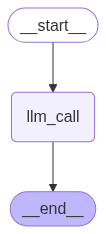

In [44]:
builder = StateGraph (MessagesState)
builder.add_node ('llm_call', llm_call)

builder.add_edge (START, 'llm_call')
builder.add_edge ('llm_call', END)

graph = builder.compile()

display (Image (graph.get_graph().draw_mermaid_png()))

In [48]:
from langchain_core.messages import HumanMessage

msg = [HumanMessage(content='What is the product of 2 and 3 added to 6')]
response = graph.invoke ({'messages': msg})

In [49]:
response

{'messages': [HumanMessage(content='What is the product of 2 and 3 added to 6', additional_kwargs={}, response_metadata={}, id='abff13fc-752f-40a4-9776-d9337af641ca'),
  AIMessage(content='First, multiply 2 and 3: \\( 2 \\times 3 = 6 \\).\n\nThen, add 6: \\( 6 + 6 = 12 \\).\n\n**The product of 2 and 3 added to 6 is \\(\\boxed{12}\\).**', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 61, 'prompt_tokens': 21, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_eede8f0d45', 'finish_reason': 'stop', 'logprobs': None}, id='run-2907b736-3253-4179-ba98-872cfe220a7b-0', usage_metadata={'input_tokens': 21, 'output_tokens': 61, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_toke

In [40]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the product of 2 and 3 added to 6
================================== Ai Message ==================================

First, multiply 2 and 3: \( 2 \times 3 = 6 \).

Next, add 6 to that product: \( 6 + 6 = 12 \).

**Answer:** \(\boxed{12}\)


## Building Agent

#### Defining the tools

In [50]:
def multiply (a: int, b: int) -> int:
    """
    Multiply a and b

    Args:
        a: first int
        b: second int
    """
    return a*b

def add (a: int, b: int) -> int:
    """
    Adds a and b

    Args:
        a: first int
        b: second int
    """
    return a+b

tools = [multiply, add]
llm_with_tool = llm.bind_tools (tools)

In [66]:
from langchain_core.messages import SystemMessage

sys_msg = SystemMessage(content="You are an arithmetic assistand that perfoms arithmetic functions. Use the tools at your discretion to perfom the aritmetic function. Cross check the response from the tool to be sure they are accurate before giving them out.")

def assistant (state: MessagesState) -> MessagesState:
    response = llm_with_tool.invoke ([sys_msg] + state ['messages'])
    return {'messages': response}

#### Building the graph

In [54]:
from langgraph.prebuilt import tools_condition, ToolNode

builder = StateGraph (MessagesState)
builder.add_node ('tools', ToolNode(tools))
builder.add_node ('assistant', assistant)

builder.add_edge (START, 'assistant')
builder.add_conditional_edges ('assistant', tools_condition)
builder.add_edge ('tools', END)

graph = builder.compile ()

print (graph.get_graph().draw_mermaid())
#display (Image (graph.get_graph().draw_mermaid_png()))

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	tools(tools)
	assistant(assistant)
	__end__([<p>__end__</p>]):::last
	__start__ --> assistant;
	tools --> __end__;
	assistant -.-> tools;
	assistant -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [59]:
msg = HumanMessage(content= "ADD 5 and 6")
response = graph.invoke ({'messages': msg})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

ADD 5 and 6
================================== Ai Message ==================================
Tool Calls:
  add (call_9uQtNRntgxdcuV32JucGtqEC)
 Call ID: call_9uQtNRntgxdcuV32JucGtqEC
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: add

11


#### Adding Reasoning to the Agent

In [67]:
builder = StateGraph (MessagesState)
builder.add_node ('tools', ToolNode(tools))
builder.add_node ('assistant', assistant)

builder.add_edge (START, 'assistant')
builder.add_conditional_edges ('assistant', tools_condition)
builder.add_edge ('tools', 'assistant')

graph = builder.compile ()

print (graph.get_graph().draw_mermaid())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	tools(tools)
	assistant(assistant)
	__end__([<p>__end__</p>]):::last
	__start__ --> assistant;
	tools --> assistant;
	assistant -.-> tools;
	assistant -.-> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [68]:
msg = HumanMessage(content= "add 10 and 37, multiply the output by 10")
response = graph.invoke ({'messages': msg})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add 10 and 37, multiply the output by 10
================================== Ai Message ==================================
Tool Calls:
  add (call_LIKTHUQE3rMOysTsnYt3UIkJ)
 Call ID: call_LIKTHUQE3rMOysTsnYt3UIkJ
  Args:
    a: 10
    b: 37
  multiply (call_acoWVwiwBMwx1vMfiEBqImNY)
 Call ID: call_acoWVwiwBMwx1vMfiEBqImNY
  Args:
    a: 47
    b: 10
================================= Tool Message =================================
Name: add

47
================================= Tool Message =================================
Name: multiply

470
================================== Ai Message ==================================

The sum of 10 and 37 is 47, and when multiplied by 10, the result is 470.


In [69]:
msg = HumanMessage(content= "who are you")
response = graph.invoke ({'messages': msg})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

who are you
================================== Ai Message ==================================

I am an arithmetic assistant ready to help you perform arithmetic functions. How can I assist you today?


In [70]:
msg = HumanMessage(content= "add 10 and 37, then divide the output by 10")
response = graph.invoke ({'messages': msg})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

add 10 and 37, then divide the output by 10
================================== Ai Message ==================================
Tool Calls:
  add (call_pYcjq4u6R2PWL13BCbOfmYI3)
 Call ID: call_pYcjq4u6R2PWL13BCbOfmYI3
  Args:
    a: 10
    b: 37
  multiply (call_Cvepn6zV3MAz2IA7mTy2UagX)
 Call ID: call_Cvepn6zV3MAz2IA7mTy2UagX
  Args:
    a: 10
    b: 1
================================= Tool Message =================================
Name: add

47
================================= Tool Message =================================
Name: multiply

10
================================== Ai Message ==================================

The sum of 10 and 37 is 47. Dividing 47 by 10 gives 4.7.
